In [1]:
import numpy as np
import pandas as pd
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
import keras
import keras.models
from keras.models import Sequential
from keras.layers import Conv2D, Lambda, MaxPooling2D
from keras.layers import Dense, Dropout, Flatten, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve

In [2]:
data = pd.read_csv('2s_shift_dataset.csv')

In [3]:
data.shape

(56091, 266)

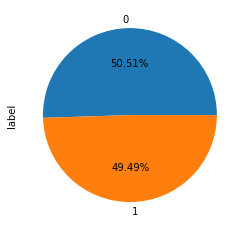

0    50.507211
1    49.492789
Name: label, dtype: float64


In [4]:
data.label.value_counts(normalize=True).plot(kind='pie', autopct='%1.2f%%',textprops={'fontsize': 10})
plt.show()
print(data.label.value_counts(normalize=True)*100)

In [5]:
train_test = np.random.permutation(data)
train_test.shape

(56091, 266)

In [6]:
train_use = train_test[0:50748]
train_use

array([[ 1.00000000e+00,  9.73725068e-02, -2.85552953e-02, ...,
        -3.07662745e-01,  6.77401118e-01,  5.28340128e+00],
       [ 0.00000000e+00, -3.10799097e-03,  1.00493566e-01, ...,
        -5.63398562e-02,  1.00123486e+00,  1.77859110e+00],
       [ 1.00000000e+00, -9.12344294e-02,  1.82401722e-01, ...,
        -3.64618287e-01, -2.49717693e-01, -2.92027216e-01],
       ...,
       [ 0.00000000e+00, -1.07607980e-01, -4.98253776e-02, ...,
        -4.27936390e-01, -3.37500863e-01, -4.67421505e-01],
       [ 0.00000000e+00, -2.10380385e-01,  1.97668756e+00, ...,
        -2.54158362e-01,  6.90631441e-02,  2.85262009e-01],
       [ 1.00000000e+00, -3.86543556e-02,  4.71945055e-01, ...,
        -3.12111613e-01, -1.62791120e-01, -3.31029024e-01]])

In [7]:
test_use = train_test[50749:]
test_use.shape

(5342, 266)

In [8]:
X_train = train_use[:,1:]
y_train = train_use[:,0]
X_test = test_use[:,1:]
y_test = test_use[:,0]

In [9]:
# 5 * 53 * 1로 변환
X_train = X_train.reshape(-1,5,53,1)
X_test = X_test.reshape(-1,5,53,1)

In [11]:
model=Sequential()

#model.add(Lambda(standardize,input_shape=(5,53,1)))   
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu", input_shape=(5,53,1)))
model.add(Conv2D(filters=64, kernel_size = (3,3), activation="relu"))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(512,activation="relu"))
model.add(Dense(256,activation="relu"))
model.add(Dense(1,activation="sigmoid"))

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [12]:
epochs = 100
batch_size = 128

# Early Stopping
es = EarlyStopping(monitor="loss",
                   patience=10,
                   verbose=1,
                   mode="max",
                   restore_best_weights=True,)


# Reduce Learning Rate
reduce_lr = ReduceLROnPlateau(monitor="loss",
                              factor=0.2,
                              patience=3,
                              verbose=1,
                              mode="max",
                              min_lr=0.00001)

In [13]:
classifier = model.fit(X_train, y_train,
                    epochs = epochs,
                    validation_data = (X_test, y_test),
                    callbacks=[es, reduce_lr])

Epoch 1/100
1586/1586 [==============================] - 15s 5ms/step - loss: 0.2509 - accuracy: 0.8898 - val_loss: 0.1284 - val_accuracy: 0.9493 - lr: 0.0010
Epoch 2/100
1586/1586 [==============================] - 8s 5ms/step - loss: 0.0812 - accuracy: 0.9705 - val_loss: 0.0746 - val_accuracy: 0.9706 - lr: 0.0010
Epoch 3/100
1586/1586 [==============================] - 8s 5ms/step - loss: 0.0488 - accuracy: 0.9829 - val_loss: 0.1374 - val_accuracy: 0.9508 - lr: 0.0010
Epoch 4/100
1584/1586 [============================>.] - ETA: 0s - loss: 0.0364 - accuracy: 0.9879
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
1586/1586 [==============================] - 8s 5ms/step - loss: 0.0363 - accuracy: 0.9879 - val_loss: 0.0663 - val_accuracy: 0.9755 - lr: 0.0010
Epoch 5/100
1586/1586 [==============================] - 8s 5ms/step - loss: 0.0090 - accuracy: 0.9970 - val_loss: 0.0111 - val_accuracy: 0.9963 - lr: 2.0000e-04
Epoch 6/100
1586/1586 [==================

In [14]:
y_pred = model.predict(X_test)

In [15]:
Y_pred = np.where(y_pred > 0.5, 1, 0)

In [16]:
print('Accuracy:{:0.4f}'.format(accuracy_score(y_test, Y_pred)))

Accuracy:0.9493


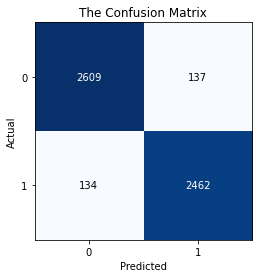

Accuracy: 94.92699363534257 %
recall: 94.83821263482281 %


In [17]:
cm = confusion_matrix(y_test, Y_pred)

def confusion_matrix_1(CM):
    fig, ax = plot_confusion_matrix(conf_mat=CM)
    plt.title("The Confusion Matrix")
    plt.ylabel("Actual")
    plt.xlabel("Predicted")
    plt.show()

    print("Accuracy: " + str((CM[1,1]+CM[0,0])/(CM[0,0]+CM[0,1]+CM[1,0]+CM[1,1])*100) + " %")
    print("recall: " + str(CM[1,1]/(CM[1,0]+CM[1,1])*100) +" %")
confusion_matrix_1(cm)